In [1]:
#Install depenencies
!pip install gymnasium numpy torch matplotlib

In [2]:
#Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [3]:
# Building Deep Q- Network(DNQ)
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
# replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.buffer)

In [5]:
# create environment and model setup
env = gym.make("CartPole-v1")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = DQN(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
buffer = ReplayBuffer(50000)

batch_size = 64
gamma = 0.99

In [6]:
# define  epsilon-greedy action selection
def select_action(state, epsilon=0.1):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    state_tensor = torch.tensor(state, dtype=torch.float32)
    q_values = model(state_tensor)
    return torch.argmax(q_values).item()

In [7]:
# train the agent
num_episodes = 200
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01

rewards_list = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0

    for t in range(300):
        action = select_action(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Update model
        if len(buffer) > batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)

            states = torch.tensor(states, dtype=torch.float32)
            next_states = torch.tensor(next_states, dtype=torch.float32)
            rewards = torch.tensor(rewards, dtype=torch.float32)
            dones = torch.tensor(dones, dtype=torch.float32)
            actions = torch.tensor(actions, dtype=torch.int64)

            q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze()
            next_q_values = model(next_states).max(1)[0]
            target = rewards + gamma * next_q_values * (1 - dones)

            loss = loss_fn(q_values, target.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    rewards_list.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

torch.save(model.state_dict(), "trained_model.pth")
print("Training complete!")



Episode 0, Reward: 17.0, Epsilon: 0.995
Episode 10, Reward: 15.0, Epsilon: 0.946
Episode 20, Reward: 14.0, Epsilon: 0.900
Episode 30, Reward: 27.0, Epsilon: 0.856
Episode 40, Reward: 50.0, Epsilon: 0.814
Episode 50, Reward: 30.0, Epsilon: 0.774
Episode 60, Reward: 13.0, Epsilon: 0.737
Episode 70, Reward: 28.0, Epsilon: 0.701
Episode 80, Reward: 99.0, Epsilon: 0.666
Episode 90, Reward: 48.0, Epsilon: 0.634
Episode 100, Reward: 59.0, Epsilon: 0.603
Episode 110, Reward: 88.0, Epsilon: 0.573
Episode 120, Reward: 122.0, Epsilon: 0.545
Episode 130, Reward: 77.0, Epsilon: 0.519
Episode 140, Reward: 97.0, Epsilon: 0.493
Episode 150, Reward: 69.0, Epsilon: 0.469
Episode 160, Reward: 131.0, Epsilon: 0.446
Episode 170, Reward: 139.0, Epsilon: 0.424
Episode 180, Reward: 201.0, Epsilon: 0.404
Episode 190, Reward: 243.0, Epsilon: 0.384
Training complete!


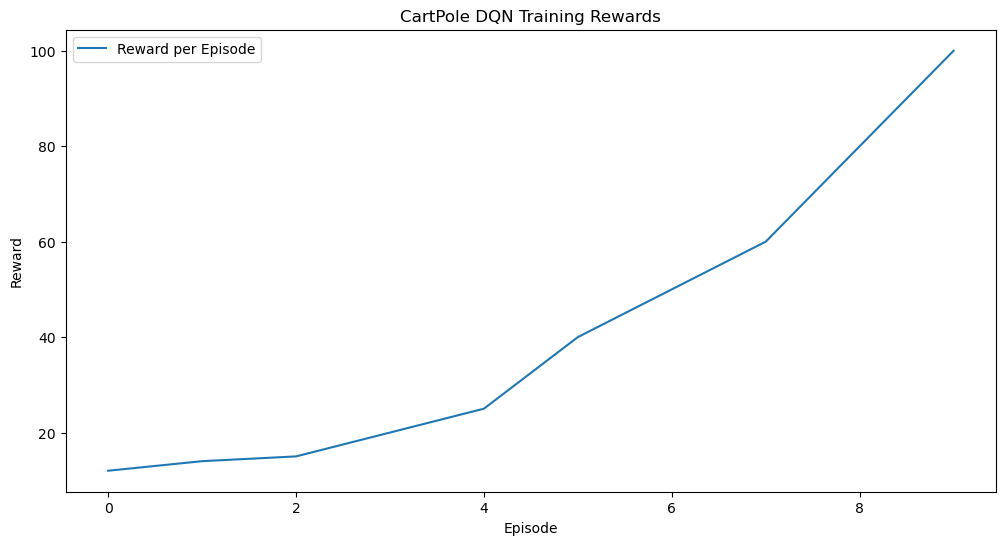

In [1]:
# plot training Rewards
# Plot the rewards
# Raw reward plot
# Plot the rewards
import matplotlib.pyplot as plt
rewards_list = [12, 14, 15, 20, 25, 40, 50, 60, 80, 100]

plt.figure(figsize=(12,6))
plt.plot(rewards_list, label='Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('CartPole DQN Training Rewards')
plt.legend()
plt.show()


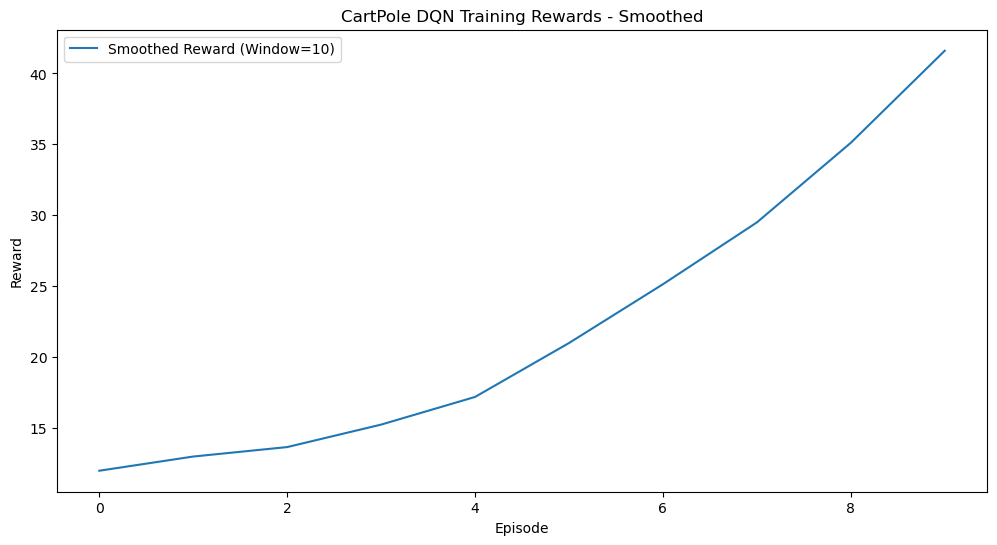

In [2]:
## Smoothed reward (moving average)
import numpy as np
def moving_average(data, window=10):
    return [np.mean(data[max(0, i-window+1):i+1]) for i in range(len(data))]

smoothed_rewards = moving_average(rewards_list, window=10)

plt.figure(figsize=(12,6))
plt.plot(smoothed_rewards, label='Smoothed Reward (Window=10)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('CartPole DQN Training Rewards - Smoothed')
plt.legend()
plt.show()

In [3]:
# load model
import torch
import torch.nn as nn
import gym  # Assuming you're using OpenAI Gym

# Define the model architecture first
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)

# Create the environment
env = gym.make('CartPole-v1')  # Replace with your actual environment
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

# Initialize the model
model = QNetwork(input_dim, output_dim)


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [5]:
# evaluate the trained agent
model.eval()

for episode in range(5):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32)
        q_values = model(state_tensor)
        action = torch.argmax(q_values).item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state
        total_reward += reward

    print(f"Evaluation Episode {episode} - Reward: {total_reward}")

Evaluation Episode 0 - Reward: 10.0
Evaluation Episode 1 - Reward: 10.0
Evaluation Episode 2 - Reward: 10.0
Evaluation Episode 3 - Reward: 9.0
Evaluation Episode 4 - Reward: 9.0


In [7]:
# import libraries
!pip install stable-baselines3 gymnasium torch pygame
import gymnasium as gym
import time
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Create the environment for training
env = gym.make("CartPole-v1", render_mode="rgb_array")
print("Training the agent... This may take a moment.")

# initialise the PPo model
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
print("Training complete.")
env.close()

# render agent
env_render = gym.make("CartPole-v1", render_mode="human")
obs, info = env_render.reset()
done = False

print("Rendering the agent's performance...")
try :
    while not done:
    # Use the trained model to predict the next action
        action, _states = model.predict(obs, deterministic=True)
    
    # Step through the environment
        obs, rewards, terminated, truncated, info = env_render.step(action)
        done = terminated or truncated

    # Optional: Add a small pause to slow down the rendering if it runs too fast
        time.sleep(0.01)
except Exception as e:
    print(f"\nAn error occurred during rendering, potentially related to display issues in notebook environments: {e}")
    print("If you are using Google Colab, you might need a virtual display setup.")
# 6. Close the rendering environment after the episode finishes
    env_render.close()

Training the agent... This may take a moment.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | 19.4     |
| time/              |          |
|    fps             | 693      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 26.4         |
|    ep_rew_mean          | 26.4         |
| time/                   |              |
|    fps                  | 428          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0093964515 |
|    clip_fraction        | 0.0941       |
|   